### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from sklearn.metrics import mean_squared_error
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

### Load and visualize the data

Names of arrays: ['u', 'th']
Shape of u and th: (35000,) (35000,)
Reshaped data of u and th: (35000, 1) (35000, 1)


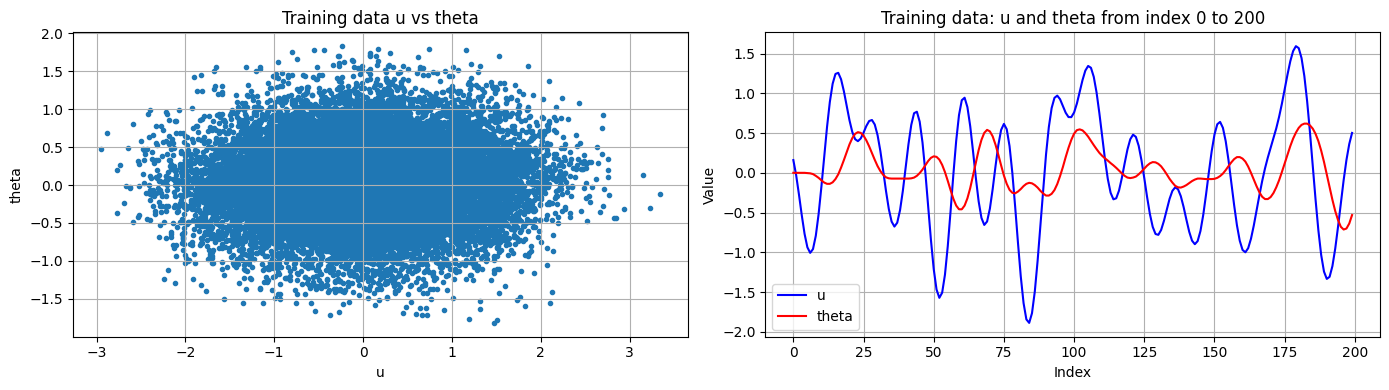

In [2]:
# Map the file names and paths
file_map = {
    "train_val_test": "disc-benchmark-files/training-val-test-data.npz",
    "hidden_test_pred": "disc-benchmark-files/hidden-test-prediction-submission-file.npz",
    "hidden_test_sim": "disc-benchmark-files/hidden-test-simulation-submission-file.npz"
}

file_name = file_map["train_val_test"]  

# Load the data 
data = np.load(file_name)
print("Names of arrays:", data.files)
print("Shape of u and th:", data['u'].shape, data['th'].shape)

# Reshape the data 
u = data['u'].reshape(-1,1)
th = data['th'].reshape(-1,1)
print("Reshaped data of u and th:", u.shape, th.shape)

# Define the division of the data for training, validation and testing
N = len(u)
train_percent = 0.70
val_test_percent = (1-train_percent) / 2

# Split data in training, testing and validation
n_train = int(train_percent * N)
n_val   = int(val_test_percent * N)

# Split dat in train val and test sets
u_train = u[:n_train]
y_train = th[:n_train]
u_val = u[n_train:n_train+n_val]
y_val   = th[n_train:n_train+n_val]
u_test = u[n_train+n_val:] 
y_test  = th[n_train+n_val:]


# Start and end index for plotting data data 
start, end = 0, 200

# Define the subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Plot the data, scatter and line plot 
axs[0].scatter(u_train, y_train, marker='.')
axs[0].set_title('Training data u vs theta')
axs[0].set_xlabel('u')
axs[0].set_ylabel('theta')
axs[0].grid(True)

axs[1].plot(u_train[start:end], label='u', color='b')
axs[1].plot(y_train[start:end], label='theta', color='r')
axs[1].set_title(f'Training data: u and theta from index {start} to {end}')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Create hyperparameters and function for features

In [ ]:
# Hyperparameter ranges for random search
param_ranges = {
    'L_th': (2, 8),       
    'L_u': (2, 8),           
    'num_inducing': (1, 15) 
}

# Define number of trails for a random s
n_trials = 100

def build_features(u, th, L_th, L_u, max_lag, N_eff):
    # Initialize X and Y
    X = np.zeros((N_eff, L_th + L_u))
    Y = np.zeros(N_eff)
    # Fill in X and Y
    for i in range(N_eff):
        k = max_lag + i
        # past L_th thetas and L_u inputs
        y_lags = [th[k-j, 0] for j in range(1, L_th+1)]
        u_lags = [u [k-j, 0] for j in range(1, L_u +1)]
        X[i, :] = y_lags + u_lags
        Y[i] = th[k, 0]

    return X, Y

### Do a random grid search for optimal hyperparameters

Trial 1/10: L_th=8, L_u=7, inducing=10, resulting RMSE=0.008002721550904939
Trial 2/10: L_th=3, L_u=3, inducing=5, resulting RMSE=0.008313397709493157
Trial 3/10: L_th=2, L_u=5, inducing=1, resulting RMSE=0.40412972464419916
Trial 4/10: L_th=4, L_u=2, inducing=5, resulting RMSE=0.006622401927314162
Trial 5/10: L_th=6, L_u=4, inducing=15, resulting RMSE=0.003974337049950597
Trial 6/10: L_th=2, L_u=3, inducing=9, resulting RMSE=0.006775367129221552
Trial 7/10: L_th=7, L_u=6, inducing=2, resulting RMSE=0.014556143344904623
Trial 8/10: L_th=5, L_u=3, inducing=8, resulting RMSE=0.004101851512101376
Trial 9/10: L_th=7, L_u=3, inducing=11, resulting RMSE=0.004030364247769448
Trial 10/10: L_th=8, L_u=4, inducing=7, resulting RMSE=0.006891655554923255
Best hyperparameters found: {'L_th': 6, 'L_u': 4, 'num_inducing': 15, 'rmse': 0.003974337049950597}


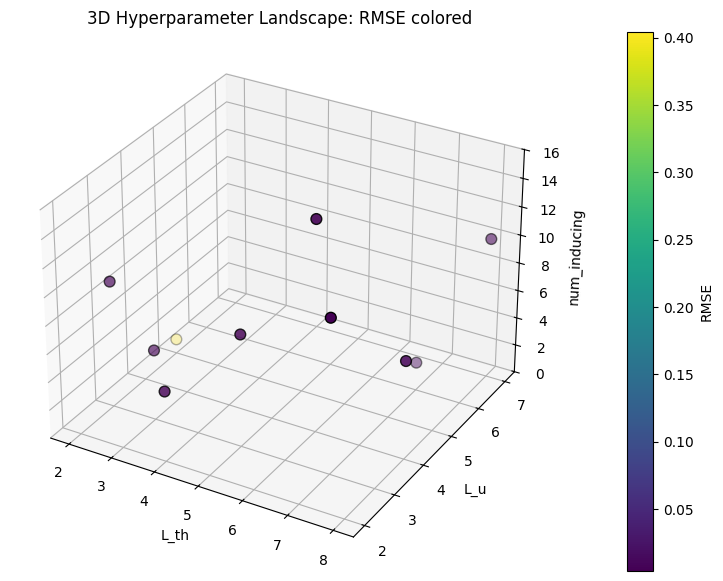

In [4]:
# Define infinity for RMSE to optimize
best = {'rmse': np.inf}
results = []
# Loop over number of trails 
for t in range(n_trials):
    
    L_th = np.random.randint(param_ranges['L_th'][0], param_ranges['L_th'][1] + 1)
    L_u = np.random.randint(param_ranges['L_u'][0], param_ranges['L_u'][1] + 1)
    num_inducing = np.random.randint(param_ranges['num_inducing'][0], param_ranges['num_inducing'][1] + 1)
    max_lag = max(L_th, L_u)
    N_eff = len(u) - max_lag

    # Build features and splits based on sampled lags
    X_all, Y_all = build_features(u, th, L_th, L_u, max_lag, N_eff)
    train_end = N_eff - n_val
    X_train, Y_train = X_all[:train_end], Y_all[:train_end]
    X_val, Y_val = X_all[train_end:], Y_all[train_end:]

    # Train sparse GP
    kernel = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
    # Randomly pick some inducing points from the training data 
    Z = X_train[np.random.choice(len(X_train), num_inducing, replace=False)]
    model = GPy.models.SparseGPRegression(X_train, Y_train[:, None], kernel=kernel, Z=Z)
    model.optimize(messages=False, max_iters=200)

    # Evaluate on validation set
    Y_pred, _ = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))
    print(f"Trial {t+1}/{n_trials}: L_th={L_th}, L_u={L_u}, inducing={num_inducing}, resulting RMSE={rmse}")
    results.append((L_th, L_u, num_inducing, rmse))
    # Always keep the best hyperparameters
    if rmse < best['rmse']:
        best = {'L_th': L_th, 'L_u': L_u, 'num_inducing': num_inducing, 'rmse': rmse}

print("Best hyperparameters found:", best)

df = pd.DataFrame(results, columns=['L_th', 'L_u', 'num_inducing', 'rmse'])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
p = ax.scatter(
    df['L_th'], df['L_u'], df['num_inducing'],
    c=df['rmse'], cmap='viridis', s=60, edgecolor='k'
)

ax.set_xlabel('L_th')
ax.set_ylabel('L_u')
ax.set_zlabel('num_inducing')
plt.title('3D Hyperparameter Landscape: RMSE colored')

# Add colorbar for RMSE values
cbar = plt.colorbar(p, pad=0.1)
cbar.set_label('RMSE')

plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0001   3.560002e+04   4.585953e+07 
    03s28  0025  -9.551647e+04   1.354807e+08 
    11s59  0089  -1.162208e+05   4.183455e+07 
    35s22  0267  -1.203617e+05   1.769117e+06 
 01m40s30  0762  -1.218807e+05   2.142955e+07 
 02m05s01  1002  -1.220609e+05   4.060943e+05 
Runtime:  02m05s01
Optimization status: Maximum number of f evaluations reached



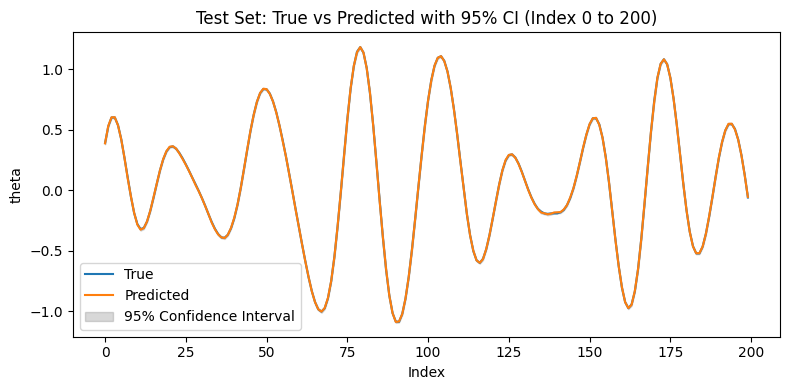

In [5]:
L_th_b, L_u_b, num_ind_b = best['L_th'], best['L_u'], best['num_inducing']
max_lag = max(L_th_b, L_u_b)
N_eff = len(u) - max_lag
X_all, Y_all = build_features(u, th, L_th_b, L_u_b, max_lag, N_eff)


n_eff_train = n_train - max_lag


X_tv, Y_tv = X_all[:n_eff_train + n_val], Y_all[:n_eff_train + n_val]
X_test, Y_test = X_all[n_eff_train + n_val:], Y_all[n_eff_train + n_val:]

kernel = GPy.kern.RBF(input_dim=X_tv.shape[1], ARD=True)
Z_tv = X_tv[np.random.choice(len(X_tv), num_ind_b, replace=False)]
final_model = GPy.models.SparseGPRegression(X_tv, Y_tv[:, None], kernel=kernel, Z=Z_tv)
final_model.optimize(messages=True)

# Predict mean and variance on test set
Y_test_pred, Y_test_var = final_model.predict(X_test)
Y_test_std = np.sqrt(Y_test_var)

# Calculate 95% confidence interval bounds
lower_bound = Y_test_pred - 1.96 * Y_test_std
upper_bound = Y_test_pred + 1.96 * Y_test_std

plt.figure(figsize=(8, 4))
plt.plot(Y_test[start:end], label='True')
plt.plot(Y_test_pred[start:end], label='Predicted')
plt.fill_between(
    np.arange(start, end),
    lower_bound[start:end].flatten(),
    upper_bound[start:end].flatten(),
    color='gray',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title(f'Test Set: True vs Predicted with 95% CI (Index {start} to {end})')
plt.xlabel('Index')
plt.ylabel('theta')
plt.legend()
plt.tight_layout()
plt.show()
